In [1]:
import os,  glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import albumentations as A

from pathlib import Path
from sklearn.model_selection import StratifiedShuffleSplit
import shutil

ModuleNotFoundError: No module named 'albumentations'

In [3]:
!pip install albumentations

ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'C:\\Users\\bitcamp\\anaconda3\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.



In [ ]:
origin_path = 'C:/KDT4/fintech/프로젝트3/data/data'

In [ ]:
name_pair = {}
old_name = os.listdir(origin_path)
for ind, oname in enumerate(old_name):
    new_name = f'class_{ind:03}'
    shutil.move(origin_path+oname,origin_path+new_name)
    name_pair[new_name] = oname
name_pair

In [5]:
ser = pd.Series(name_pair)
ser.to_csv('class_name_pair_20220330.csv')

In [6]:
for dr in os.listdir(origin_path):
    for ind, img in enumerate(os.listdir(origin_path+dr)):
        shutil.move(origin_path+dr+'/'+img,origin_path+dr+f'/{dr}_{ind:03}.jpg')

In [65]:
train_path = Path('D:/Project3/data/train') # train test로 구분한 파일 저장 경로
val_path = Path('D:/Project3/data/val')
test_path = Path('D:/Project3/data/test')

train_path.mkdir(exist_ok=True)
val_path.mkdir(exist_ok=True)
test_path.mkdir(exist_ok=True)

In [63]:
data_path = Path('D:/Project3/padding/') # 원본 파일들 저장 경로
data = []
cla = []
for d in data_path.glob('*'):
    for f in d.glob('*.jpg'):
        data.append(f)
        cla.append(d.stem)
data = np.array(data)
cla = np.array(cla)
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
cla2 = encoder.fit_transform(cla)
cla2

array([  0,   0,   0, ..., 563, 563, 563], dtype=int64)

In [58]:
pd.DataFrame(data)[1].value_counts(ascending=True)

class_505      4
class_483      4
class_373      4
class_290      4
class_235      5
            ... 
class_154     79
class_124     84
class_129     87
class_029    100
class_134    106
Name: 1, Length: 564, dtype: int64

In [67]:
# st = StratifiedShuffleSplit(1, train_size = 0.75) # 얘가 핵심, Stratify 유지하면서 쪼개주는 역할

# sv = StratifiedShuffleSplit(1, train_size = 2/3) # 얘가 핵심, Stratify 유지하면서 쪼개주는 역할
# train_ix, test_ix = next(st.split(data[:,0],data[:,1])) # next가 뭐하는 놈인지 기억안난다 암튼 나눠준거다
from sklearn.model_selection import train_test_split
train_data, test_data, train_cla, test_cla = train_test_split(data, cla, test_size=0.25, stratify=cla)
train_data, val_data, train_cla, val_cla = train_test_split(train_data, train_cla, test_size=1/3, stratify=train_cla)
# data2 = data[train_ix]
# train_ix, val_ix = next(sv.split(data2[:,0],data2[:,1])) # next가 뭐하는 놈인지 기억안난다 암튼 나눠준거다

print(len(train_data), len(test_data), len(val_data))

7631 3816 3816


In [68]:
train_set, test_set, val_set = data[train_ix], data[test_ix], data[val_ix]
train_set

array([WindowsPath('D:/Project3/padding/class_256/class_256_017.jpg'),
       WindowsPath('D:/Project3/padding/class_047/class_047_035.jpg'),
       WindowsPath('D:/Project3/padding/class_310/class_310_012.jpg'),
       ...,
       WindowsPath('D:/Project3/padding/class_179/class_179_016.jpg'),
       WindowsPath('D:/Project3/padding/class_197/class_197_024.jpg'),
       WindowsPath('D:/Project3/padding/class_074/class_074_005.jpg')],
      dtype=object)

In [69]:
for p, c in zip(train_data,train_cla):
    (train_path / c).mkdir(exist_ok=True)
    shutil.copy(p, train_path.joinpath(*p.parts[-2:]))
for p, c in zip(test_data,test_cla):
    (test_path / c).mkdir(exist_ok=True)
    shutil.copy(p, test_path.joinpath(*p.parts[-2:]))
for p, c in zip(val_data,val_cla):
    (val_path / c).mkdir(exist_ok=True)
    shutil.copy(p, val_path.joinpath(*p.parts[-2:]))

In [3]:
def padding(img):
    h,w,c = img.shape
    set_size = max(h,w)
    delta_w = set_size-w
    delta_h = set_size-h
    value = [0,0,0]
    for i in range(3):
        value[i] = int((np.sum(img[:,[0,-1],i])+np.sum(img[[0,-1],:,i]))/(np.size(img[:,[0,-1],i])+np.size(img[[0,-1],:,i])))
#         value[i] = int((np.mean(img[[0,-1],[0,-1],i])))
    top,bottom=delta_h//2,delta_h-(delta_h//2)
    left,right = delta_w//2, delta_w-(delta_w//2)
    
    new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,value=value)
    return new_img

In [4]:
def glassblur(drink):
    transform = A.GlassBlur(sigma=0.7, max_delta=4, iterations=2, always_apply=False, mode='fast', p=1) 
    glass_drink = transform(image=drink)['image']
    return glass_drink

def clahe(drink):
    transform = A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=1) 
    clahe_drink = transform(image=drink)['image']
    return clahe_drink

def rd_gam(drink):
    transform = A.RandomGamma(gamma_limit=(80, 120), eps=None, always_apply=False, p=1) 
    rd_gam_drink = transform(image=drink)['image']
    return rd_gam_drink
    
def emboss(drink):
    transform = A.Emboss(alpha=(0.2, 0.5), strength=(0.2, 0.7), always_apply=False, p=1) 
    emboss_drink = transform(image=drink)['image']
    return emboss_drink

def equalize(drink):
    transform = A.Equalize(mode='cv', by_channels=True, mask=None, mask_params=(), always_apply=False, p=1) 
    equalize_drink = transform(image=drink)['image']
    return equalize_drink

def ison(drink):
    transform = A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), always_apply=False, p=1) 
    ison_drink = transform(image=drink)['image']
    return ison_drink

def solar(drink):
    transform = A.Solarize(threshold=128, always_apply=False, p=1) 
    solar_drink = transform(image=drink)['image']
    return solar_drink

def chandrop(drink):
    transform = A.ChannelDropout(channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=0.5) 
    chandrop_drink = transform(image=drink)['image']
    return chandrop_drink

def colji_a(drink):
    transform = A.ColorJitter(brightness=0.3, contrast=0.5, saturation=0.2, hue=0.5, always_apply=False, p=1) 
    colji_a_drink = transform(image=drink)['image']
    return colji_a_drink

def colji_b(drink):
    transform = A.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.5, hue=0.1, always_apply=False, p=1) 
    colji_b_drink = transform(image=drink)['image']
    return colji_b_drink

def colji_c(drink):
    transform = A.ColorJitter(brightness=0.5, contrast=0.2, saturation=0.1, hue=0.3, always_apply=False, p=1) 
    colji_c_drink = transform(image=drink)['image']
    return colji_c_drink
tit = np.array([ glassblur, clahe, rd_gam, emboss, equalize, ison, solar, chandrop, colji_a, colji_b, colji_c ])
titls = np.array([ 'glassblur', 'clahe', 'rd_gam', 'emboss', 'equalize', 'ison', 'solar', 'chandrop', 'colji_a', 'colji_b','colji_c' ])

In [6]:
save_aug_path = 'D:/Project3/smallsize2/'
errorlst =[]
if not os.path.exists(save_aug_path):
    os.mkdir(save_aug_path)
for work in ['train','test','val']:
    origin_path = f'D:/Project3/data/{work}/'
    save_path = f'{save_aug_path}{work}/'
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    for cla in os.listdir(origin_path):
        if not os.path.exists(save_path+cla):
            os.mkdir(save_path+cla)
        for img in os.listdir(origin_path+cla):
            tit_rotation = []
            try:
                drink = cv2.imread(f"{origin_path+cla}/{img}")
                drink = cv2.cvtColor(drink, cv2.COLOR_BGR2RGB)
            except:
                print(img)
                errorlst.append(img)
                continue
            rc = np.random.choice([i for i in range(11)],6,False)
            for f in tit[rc]:
                tiva = f(drink)
                rotation=[]
                for r in range(1):
                    transform = A.Rotate(limit=180, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=1)
                    rotate_drink = transform(image=padding(tiva))['image']
                    rotation.append(rotate_drink)
                tit_rotation.append(rotation)
            for i, aug in zip(rc,tit_rotation):
                for t,rot in enumerate(aug):
                    new_img = cv2.cvtColor(rot, cv2.COLOR_RGB2BGR)
                    cv2.imwrite(f"{save_path+cla}/{img[:-4]}_{titls[i]}_{t}.jpg", new_img)
                    

In [76]:
img

'class_242_030.jpg'

In [59]:
file_path = 'D:/Project3/padding'

for dr in os.listdir(file_path)[:20]:
    images = os.listdir('/'.join([file_path,dr]))
    if not os.path.exists(save_path+'/'+dr):
        os.mkdir(save_path+'/'+dr)
    for image in images:
        img = cv2.imread('/'.join([file_path,dr,image]), cv2.IMREAD_COLOR)
        new_img = padding(img)
        cv2.imwrite('/'.join([save_path,dr,image]),new_img)
#         except:
#             print('/'.join([file_path,dr,image]))
# #             os.remove('/'.join([file_path,dr,image]))


In [11]:
img = cv2.imread('/'.join(['D:/Project3/padding/class_023','class_023_010.jpg']))

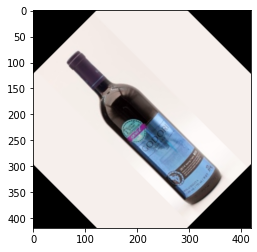

In [39]:
def im_rotate(img, degree): 
    img = padding(img)
    h, w = img.shape[:-1] 
    crossLine = int(((w * h + h * w) ** 0.5)) 
    centerRotatePT = int( max(h, w) / 2), int( max(h, w) / 2) 
    new_h, new_w = max(h, w) , max(h, w)
    rotatefigure = cv2.getRotationMatrix2D(centerRotatePT, degree, 1) 
    result = cv2.warpAffine(img, rotatefigure, (new_w, new_h)) 
    return result
pimg = padding(img)
r = A.Rotate(limit=180, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=1)
# rimg = r(image=pimg)['image']
plt.imshow(im_rotate(img, 45))
# plt.imshow(img)
plt.show()

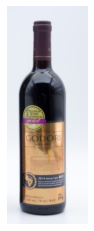

In [12]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)),plt.axis('off')
plt.show()

In [48]:
new_img = cv2.resize(img,(96,96))

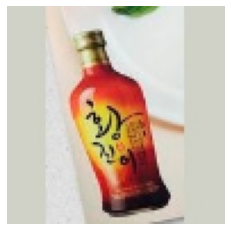

In [49]:
plt.imshow(cv2.cvtColor(new_img,cv2.COLOR_BGR2RGB)),plt.axis('off')
plt.show()

In [19]:
new_img

array([[[199, 210, 208],
        [199, 210, 208],
        [199, 210, 208],
        ...,
        [199, 210, 208],
        [199, 210, 208],
        [199, 210, 208]],

       [[199, 210, 208],
        [199, 210, 208],
        [199, 210, 208],
        ...,
        [199, 210, 208],
        [199, 210, 208],
        [199, 210, 208]],

       [[199, 210, 208],
        [199, 210, 208],
        [199, 210, 208],
        ...,
        [199, 210, 208],
        [199, 210, 208],
        [199, 210, 208]],

       ...,

       [[199, 210, 208],
        [199, 210, 208],
        [199, 210, 208],
        ...,
        [199, 210, 208],
        [199, 210, 208],
        [199, 210, 208]],

       [[199, 210, 208],
        [199, 210, 208],
        [199, 210, 208],
        ...,
        [199, 210, 208],
        [199, 210, 208],
        [199, 210, 208]],

       [[199, 210, 208],
        [199, 210, 208],
        [199, 210, 208],
        ...,
        [199, 210, 208],
        [199, 210, 208],
        [199, 210, 208]]

In [ ]:
orgin_path = 
os.mkdir('')